Saaksshi Jilhewar - sjilhewa \
Gauri Dalwankar - gdalwank


Ingesting both train and test dataset into Postgres Database table:

In [16]:
#importing libraries

import findspark
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark import SparkFiles
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import monotonically_increasing_id

from kafka import KafkaProducer
from kafka import KafkaConsumer

import tweepy
import time
import sys
import json

import matplotlib.pyplot as plt

import seaborn as sns
from IPython import display

In [17]:
#creating spark session

findspark.init()
findspark.find()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MQTT") \
    .getOrCreate()

spark = SparkSession.builder.appName("mqttProject").getOrCreate()
sc    = spark.sparkContext

sqlContext = SQLContext(sc)

In [18]:
#accessing dataset

train = spark.read.csv( (r"data folder\train70_augmented.csv"),header=True, inferSchema= True)
test = spark.read.csv( (r"data folder\test30_augmented.csv"),header=True, inferSchema= True)

In [19]:
#ingesting only a fraction of dataset because system kept showing error or no response from spark
#creating dataframe

x = train.head(140000)
y = test.head(60000)

DF_train = spark.createDataFrame(x)
DF_test = spark.createDataFrame(y)

#combining both dataframes into one

DF = DF_train.union(DF_test)



In [20]:
#change column name

DF=DF.toDF(*(c.replace('.', '_') for c in DF.columns))

In [21]:
#ingesting through postgres, creating schema

db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="17032007"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt.MQTT"

DF.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()


DF= sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

In [22]:
#check schema

DF.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: long (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- m

Adding a column to the database table which contains "Train" for the train dataset and "Test" for the test dataset:

In [23]:
#population of data
#addicition of id column for better accessibility, to add column column that differentiates between train and test datasets
DF_with_id_column = DF.withColumn("id", monotonically_increasing_id())
field_addition = DF_with_id_column.withColumn("Field", when(DF_with_id_column.id <= "140000", "train").otherwise("test"))


#dropping the added id column, which was purposefully added

DF = field_addition.drop(field_addition.id)
DF.show(vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 1.0E-4     
 tcp_len                    | 14         
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000030 
 mqtt_kalive                | 0.0        
 mqtt_len                   | 12.0       
 mqtt_msg                   | 30         
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 3.0        
 mqtt_proto_len             | 0.0 


Finding the average length of an MQTT message:

In [24]:
#conducting analytics

length_mqtt_msg = DF.withColumn("Length of message", when(DF.Field == "train", F.length("mqtt_msg")))
average_lengeth_mqtt_msg = length_mqtt_msg.agg({"Length of message":'avg'})

length_mqtt_len = DF.withColumn("Length", when(DF.Field == "train", F.length("mqtt_len")))
average_length_mqtt_len = length_mqtt_len.agg({"Length":'avg'})

DF = DF.drop('Length of message', 'Length')

In [25]:
#average length of an MQTT message captured in the train dataset

average_lengeth_mqtt_msg.show()

+----------------------+
|avg(Length of message)|
+----------------------+
|    10.066142384697253|
+----------------------+



In [26]:
average_length_mqtt_len.show() 

+------------------+
|       avg(Length)|
+------------------+
|3.4267755230319783|
+------------------+



Finding the average length of tcp message:

In [27]:
#average length of the TCP message, for each target

DF.groupBy('target').avg('tcp_len').show()

+----------+------------------+
|    target|      avg(tcp_len)|
+----------+------------------+
|   slowite|3.6376911692155893|
|bruteforce|3.2657206870799103|
|     flood|13638.556958190264|
| malformed|22.277416794801844|
|       dos|309.61633313119063|
|legitimate| 7.779191526848997|
+----------+------------------+



Building a python function that uses PySpark to list the most frequent X TCP flags where X is a user-provided parameter


In [28]:
'''Python function that uses PySpark to list the most frequent X TCP flags 
where X is a user-provided parameter'''

def most_frequent_TCP_flag(x):
    frequent_X_TCP_flag = DF.groupBy('tcp_flags').count()
    most_frequent_X_TCP_flag = frequent_X_TCP_flag.orderBy("count",ascending=False)
    most_frequent_X_TCP_flag.show(int(x))
    return 0

In [29]:
# X is a user-provided parameter

X = input("provide the parameter between 1-6")

#testing the built function: most_frequent_TCP_flag(x)

most_frequent_TCP_flag(X)

provide the parameter between 1-6 4
+----------+-----+
| tcp_flags|count|
+----------+-----+
|0x00000018|98964|
|0x00000010|77909|
|0x00000012| 6296|
|0x00000002| 6260|
+----------+-----+
only showing top 4 rows



In [15]:
#kafka Producer

# Update the keys with correct values

bearer_token= r"AAAAAAAAAAAAAAAAAAAAAD%2BcigEAAAAALaWgPXGv8lscmZLNV2bpR7KtImA%3DbluVQxOtRfKheRy8DAhOfGCIjUTD5SOjs4vgtscQ1EYmXn7WsD"
api_key = "ILOexBgajpvDYhELtvJV1CFVF"
api_secret = "8izksknIbf9sV61ouKLRmNtpRZV28Q9ckMFdYZpO0JxdnEgria"
access_token = '1572614118909116417-EmNSuqn8LcoNDRmjpm9RwB9WXi8iM9'
access_token_secret = 'kLnSxfkpo2mVqh4dmOVuFsfTLPSuoxOqKFKcmaPHTrmHN'

tweepy.Client(bearer_token,api_key,api_secret,access_token,access_token_secret)
auth = tweepy.OAuth1UserHandler(api_key,api_secret,access_token,access_token_secret)
api = tweepy.API(auth)

search_terms = ['slowite','bruteforce','flood','malformed','dos','legitimate']

producer = KafkaProducer(bootstrap_servers='localhost:9092')

topic_name = "testing11"

class MyStream(tweepy.StreamingClient):
    def on_connect(self):
        print("connected")
    
    def on_tweet(self,tweet):
        if tweet.referenced_tweets == None:
            end=time.time()
            if end>start+300:
                sys.exit()
            else:
                print (tweet.text)
                producer.send(topic_name,tweet.text.encode('utf-8'))
                #time.sleep(0.1)
            
            
stream = MyStream(bearer_token=bearer_token)
start=time.time()
for term in search_terms:
    stream.add_rules(tweepy.StreamRule(term))
    
stream.filter(tweet_fields=["referenced_tweets"])

connected
Entra Balde.
Los dos laterales izquierdos del partido son Raum Alejandro.
Jordi Alba lleva dos partidos a un nivel descomunal.
Que jogaço #ESP e #GER. Um dos melhores que assisti até agora.
solo tengo dos mutis de España
Carvajal y Koke vaya tela, van a ver cual de los dos lo hace peor.
Llevo dos días con feliz cumpleaños ferxxo pegada no máaaasss
Mate y malas decisiones, dos cosas que nunca me canso de tomar!
ABEL DEIXA EU SER A MAE DOS FILHOS PFV
Perfis do Exército nas redes ganham 7 milhões de seguidores após eleições e superam Exército dos EUA. https://t.co/ZWVn4fkPCf https://t.co/1zHS3UKA1y
O tanto de tomada de decisão errada da Alemanha é algo assustador. A bola queima no pé dos atacantes. Que geração ruim
me preguntó cada dos segundos si el me extraña.
Resident Evil Remake não tinha obrigação nenhuma de ser um dos melhores jogos ja feitos https://t.co/Ge5Fts7evE
Como pode esses artistes apoiarem essa esquerda q tem conluio com o Alexandre de Mores q estão praticando de

SystemExit: 

C:\Users\gauri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#kafka Consumer

topic_name = 'testing11'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'))

In [ ]:
streamed_data = None
i = 0
for message in kafka_consumer:
    i = i + 1
    if i > 50:
        break
    # Read the tweet from the topic
    data = [message.value]
    tweet = spark.createDataFrame(data,"string")
    # clean the tweet and extract the hashtag! 
    # Notice I'm picking one tweet at a time in a separate dataframe to avoid too-large dataframes
    # explode() returns a new row for each element in the given array or map.
    #alias() returns this column aliased with a new name or names

    if streamed_data is None:
        streamed_data = tweet.withColumn('word', explode(split(col('value'), ' '))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False)\
                    .filter(col('word').isin(search_terms))
    else:
        streamed_data = streamed_data.union(tweet.withColumn('word', explode(split(col('value'), ' '))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False)\
                    .filter(col('word').isin(search_terms)))
    
# streamed_data.show()

C:\Users\gauri\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
streamed_data.show()

+----------+-----+
|      word|count|
+----------+-----+
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|legitimate|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
|       dos|    1|
+----------+-----+
only showing top 20 rows



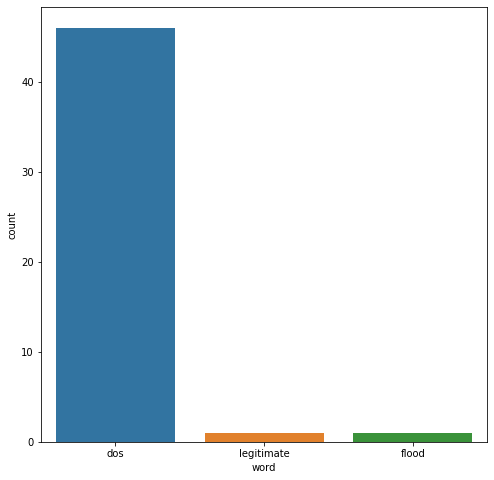

In [ ]:

plt.figure( figsize = ( 8, 8 ) )

final_list= streamed_data.groupBy("word").count().sort("count",ascending=False).toPandas()
sns.barplot( x="word", y="count", data=final_list)
plt.show()

After ingesting tweets using kafka, "dos" target is the most popular target. We need to consider that Legitimate is not a target.